In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Importing dataset**

In [ ]:
dataset = pd.read_csv('pubfig83.csv')
X = dataset.iloc[:, :].values

In [ ]:
labels = pd.read_csv('labels.csv')
y = labels.iloc[:, 0].values
y_names = labels.iloc[:, 1].values

**Check sample image**

In [0]:
def array_to_image(image):
    return np.reshape(image, (100,100,3))

In [0]:
i = array_to_image(X[0,:])

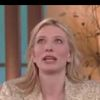

53

In [14]:
from google.colab.patches import cv2_imshow
cv2_imshow(i)


**Split dataset**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
batch_size = len(X_train)

'Cate Blanchett'

In [38]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

array([1, 'Cate Blanchett'], dtype=object)

**Rescaling**

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Train
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Test
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

feature_columns = [tf.feature_column.numeric_column('x', shape = X_train_scaled.shape[1:])]


In [0]:
X_train_scaled.shape[1:]

**Model**

In [0]:
def cnn_model_fn(features, labels, mode):
    
    """Model function for CNN."""
  # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 3])

  # Convolutional Layer
    conv1 = tf.layers.conv3d( inputs=input_layer, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
  # Pooling Layer
    pool1 = tf.layers.max_pooling3d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer
    conv2 = tf.layers.conv3d( inputs=pool1, filters=36, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 36])
    dense = tf.layers.dense(inputs=pool2_flat, units=7 * 7 * 36, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics Evaluation mode
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

Estimator

In [0]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="train/pubfig_convnet_model")

Logs

In [0]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

Train model

In [0]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_scaled},
    y=y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=16000,
    hooks=[logging_hook])

Evaluate

In [0]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test_scaled},
    y=y_test,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)